In [1]:
import pandas as pd

def transform_age_classes_one_hot(csv_path, output_csv):
    """
    Transforms the age column into one-hot encoded classes and maps them as follows:
    10-20 -> AGE_CLASS_0
    20-30 -> AGE_CLASS_1
    30-40 -> AGE_CLASS_2
    40-50 -> AGE_CLASS_3
    50+   -> AGE_CLASS_4

    Parameters:
    - csv_path (str): The path to the input CSV file.
    - output_csv (str): The path to save the transformed CSV file.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Define the bins and corresponding labels (age classes)
    bins = [10, 20, 30, 40, 50, float('inf')]  # float('inf') is used to cover ages greater than 50
    labels = [0, 1, 2, 3, 4]  # New labels for the classes

    # Create a new column 'AGE_CLASS' based on the age bins
    df['AGE_CLASS'] = pd.cut(df['AGE'], bins=bins, labels=labels, right=False)

    # Drop rows where the AGE column is not in the defined range (i.e., NaN in AGE_CLASS)
    df = df.dropna(subset=['AGE_CLASS'])

    # Convert AGE_CLASS to integer type (as cut returns category type)
    df['AGE_CLASS'] = df['AGE_CLASS'].astype(int)

    # One-hot encode the AGE_CLASS column
    one_hot_encoded_df = pd.get_dummies(df, columns=['AGE_CLASS'], prefix='AGE_CLASS')

    # Save the one-hot encoded DataFrame to a new CSV file
    one_hot_encoded_df.to_csv(output_csv, index=False)

    print(f"Transformed data with one-hot encoded age classes saved to {output_csv}")

# Example usage:
csv_path = 'demographics_csv/metadata_participants.csv'  # Your input CSV path
output_csv = 'demographics_csv/age_one_hot_all.csv'  # Output CSV path

transform_age_classes_one_hot(csv_path, output_csv)


D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\pandas\core\arrays\categorical.py:528: RuntimeWarning: invalid value encountered in cast
  fill_value = lib.item_from_zerodim(np.array(np.nan).astype(dtype))


Transformed data with one-hot encoded age classes saved to demographics_csv/age_one_hot_all.csv


In [2]:
import pandas as pd

# Load the CSV file into a pandas DataFrame
csv_path = 'demographics_csv/age_one_hot_all.csv'  # Replace with your actual CSV file path
df = pd.read_csv(csv_path)

# Display the first 5 rows of the DataFrame
print(df.head())


   PARTICIPANT_ID  AGE  GENDER  HAS_TAKEN_TYPING_COURSE COUNTRY  LAYOUT  \
0               3   30    none                        0      US  qwerty   
1               5   27  female                        0      MY  qwerty   
2               7   13  female                        0      AU  qwerty   
3              23   21  female                        0      IN  qwerty   
4              24   21  female                        0      PH  qwerty   

  NATIVE_LANGUAGE FINGERS  TIME_SPENT_TYPING KEYBOARD_TYPE  ...  AVG_WPM_15  \
0              en     1-2                  8          full  ...     61.9483   
1              en     7-8                  6        laptop  ...     72.8871   
2              en     7-8                  0        laptop  ...     24.1809   
3              en     3-4                  0          full  ...     24.7112   
4              tl     7-8                  1        laptop  ...     45.3364   

      AVG_IKI      ECPC      KSPC     ROR  AGE_CLASS_0  AGE_CLASS_1  \
0  

In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, accuracy_score

def balance_dataset(csv_path, output_csv):
    """
    Balances the dataset so that each class has an equal number of samples by undersampling.
    
    Parameters:
    - csv_path (str): The path to the input CSV file with one-hot encoded age classes.
    - output_csv (str): The path to save the balanced CSV file.
    """
    # Load the CSV file into a pandas DataFrame
    df = pd.read_csv(csv_path)

    # Assuming that AGE_CLASS columns are one-hot encoded, first identify the classes
    age_classes_columns = [col for col in df.columns if col.startswith('AGE_CLASS_')]
    
    # Create a new column 'AGE_CLASS' that contains the original class number (not one-hot encoded)
    df['AGE_CLASS'] = df[age_classes_columns].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))

    # Find the minimum number of samples in any age class
    min_samples = df['AGE_CLASS'].value_counts().min()

    # Balance the dataset by undersampling each class to have `min_samples` number of rows
    balanced_df = df.groupby('AGE_CLASS').apply(lambda x: x.sample(n=min_samples, random_state=42)).reset_index(drop=True)

    # Drop the temporary 'AGE_CLASS' column since you still have one-hot encoded columns
    balanced_df = balanced_df.drop(columns=['AGE_CLASS'])

    # Save the balanced DataFrame to a new CSV file
    balanced_df.to_csv(output_csv, index=False)

    print(f"Balanced dataset saved to {output_csv}")

# Step 1: Create the balanced dataset
input_csv = 'demographics_csv/age_one_hot_all.csv'  # Input CSV path
output_csv = 'demographics_csv/balanced_age.csv'  # Output CSV path

balance_dataset(input_csv, output_csv)

Balanced dataset saved to demographics_csv/balanced_age.csv


In [4]:
import pandas as pd

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Identify the AGE_CLASS columns
age_class_columns = [col for col in df.columns if col.startswith('AGE_CLASS_')]

# Calculate the share of each AGE_CLASS
age_class_shares = df[age_class_columns].sum() / len(df)

# Print the share of each AGE_CLASS
print(age_class_shares)

AGE_CLASS_0    0.2
AGE_CLASS_1    0.2
AGE_CLASS_2    0.2
AGE_CLASS_3    0.2
AGE_CLASS_4    0.2
dtype: float64


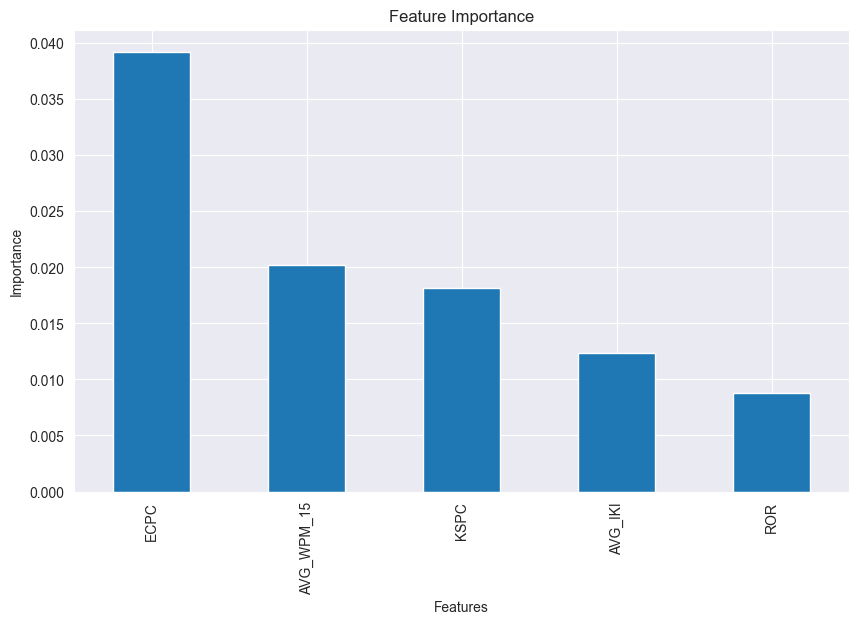

Accuracy: 0.26


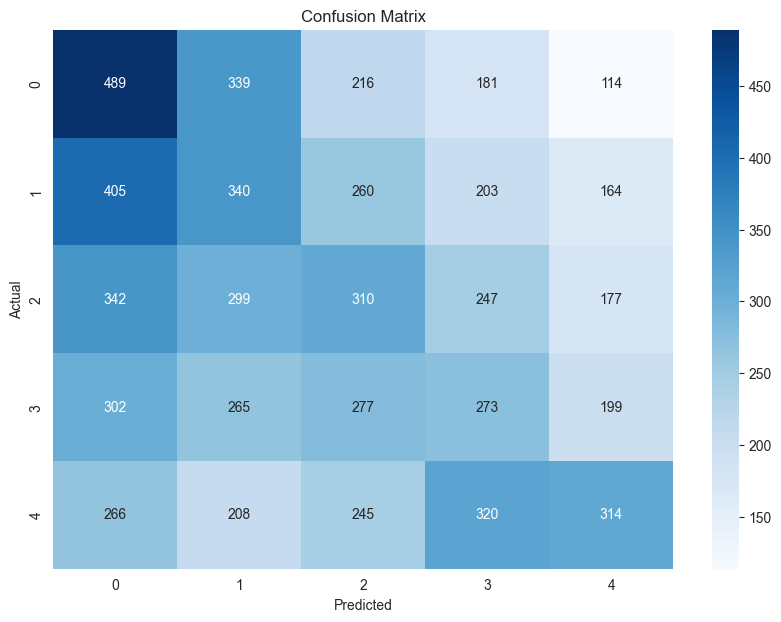

In [5]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_feature_importance(csv_path):
    # Step 1: Read the CSV file
    df = pd.read_csv(csv_path, low_memory=False)

    # Step 2: Preprocess data
    df = df.dropna()
    label_encoder = LabelEncoder()
    df['GENDER'] = label_encoder.fit_transform(df['GENDER'])
    features = [
        'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR'
    ]
    X = df[features]
    y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
    participant_ids = df['PARTICIPANT_ID']

    # Ensure unique PARTICIPANT_IDs in train and test sets
    unique_ids = participant_ids.unique()
    train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
    train_mask = participant_ids.isin(train_ids)
    test_mask = participant_ids.isin(test_ids)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train KNN model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    # Calculate feature importance using permutation importance
    result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    importance = result.importances_mean

    # Visualize feature importance
    feature_importance = pd.Series(importance, index=features)
    feature_importance.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.show()

    # Print accuracy
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Print confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

# Example usage:
csv_path = 'demographics_csv/balanced_age.csv'  # Path to the CSV file
visualize_feature_importance(csv_path)

In [6]:
# knn saved 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_feature_importance(csv_path):
    # Step 1: Read the CSV file
    df = pd.read_csv(csv_path, low_memory=False)

    # Step 2: Preprocess data
    df = df.dropna()
    label_encoder = LabelEncoder()
    df['GENDER'] = label_encoder.fit_transform(df['GENDER'])
    features = [
        'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR'
    ]
    X = df[features]
    y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
    participant_ids = df['PARTICIPANT_ID']

    # Ensure unique PARTICIPANT_IDs in train and test sets
    unique_ids = participant_ids.unique()
    train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
    train_mask = participant_ids.isin(train_ids)
    test_mask = participant_ids.isin(test_ids)

    X_train, X_test = X[train_mask], X[test_mask]
    y_train, y_test = y[train_mask], y[test_mask]

    # Scale features
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Train KNN model
    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(X_train, y_train)

    # Calculate feature importance using permutation importance
    result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
    importance = result.importances_mean

    # Visualize and save feature importance
    feature_importance = pd.Series(importance, index=features)
    feature_importance.sort_values(ascending=False, inplace=True)

    plt.figure(figsize=(10, 6))
    feature_importance.plot(kind='bar')
    plt.title('Feature Importance')
    plt.xlabel('Features')
    plt.ylabel('Importance')
    plt.savefig('fip_knn_agepred.pdf', bbox_inches='tight')
    plt.close()

    # Save feature importance as CSV
    feature_importance_df = feature_importance.reset_index()
    feature_importance_df.columns = ['Feature', 'Importance']
    feature_importance_df.to_csv('fip_knn_agepred.csv', index=False)

    # Print accuracy
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')

    # Print and save confusion matrix
    conf_matrix = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.savefig('confusion_matrix_knn.pdf', bbox_inches='tight')
    plt.close()

    # Save confusion matrix as CSV
    conf_matrix_df = pd.DataFrame(conf_matrix, index=knn.classes_, columns=knn.classes_)
    conf_matrix_df.to_csv('cm_knn_agepred.csv')

# Example usage:
csv_path = 'demographics_csv/balanced_age.csv'  # Path to the CSV file
visualize_feature_importance(csv_path)

Accuracy: 0.26


Random Forest Classifier Accuracy:  0.27387120651369357
              precision    recall  f1-score   support

           0       0.29      0.35      0.32      1338
           1       0.24      0.24      0.24      1351
           2       0.25      0.23      0.24      1346
           3       0.24      0.21      0.23      1365
           4       0.34      0.34      0.34      1355

    accuracy                           0.27      6755
   macro avg       0.27      0.27      0.27      6755
weighted avg       0.27      0.27      0.27      6755


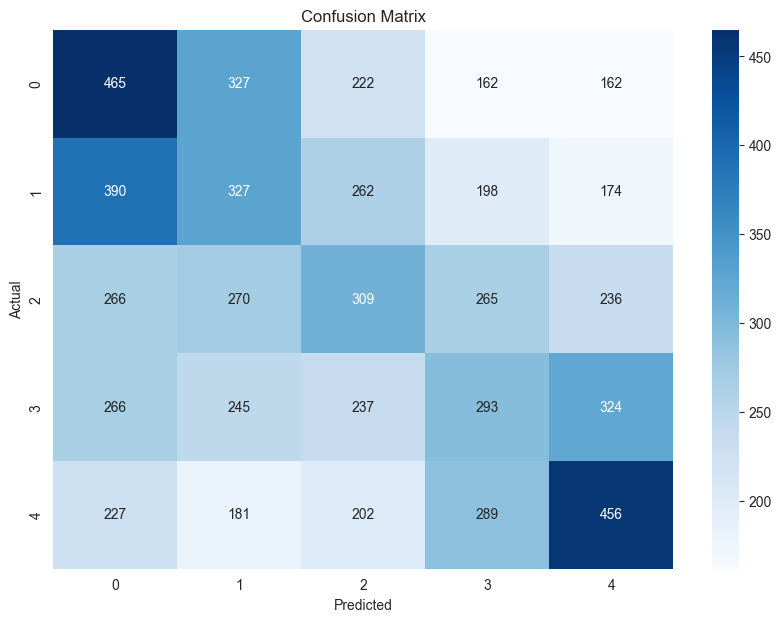

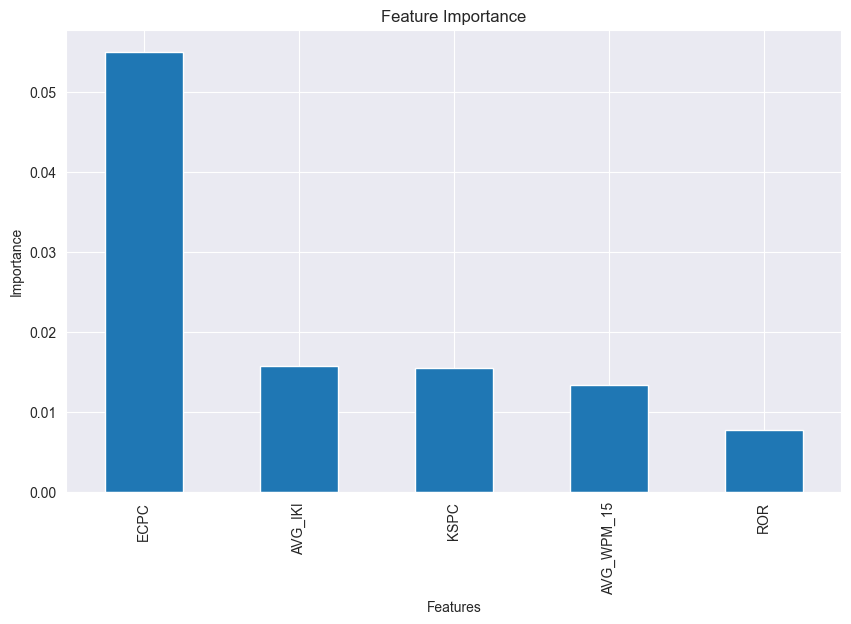

In [7]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Specify the features to be used
features = [
    'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR'
]

# Separate features and target
X = df[features]
y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
participant_ids = df['PARTICIPANT_ID']

# Encode any categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Ensure unique PARTICIPANT_IDs in train and test sets
unique_ids = participant_ids.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_mask = participant_ids.isin(train_ids)
test_mask = participant_ids.isin(test_ids)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Accuracy: ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Print confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate feature importance using permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
importance = result.importances_mean

# Visualize feature importance
feature_importance = pd.Series(importance, index=features)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

In [8]:
# save rf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Specify the features to be used
features = [
    'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR'
]

# Separate features and target
X = df[features]
y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
participant_ids = df['PARTICIPANT_ID']

# Encode any categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Ensure unique PARTICIPANT_IDs in train and test sets
unique_ids = participant_ids.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_mask = participant_ids.isin(train_ids)
test_mask = participant_ids.isin(test_ids)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Random Forest classifier
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Make predictions
y_pred_rf = rf.predict(X_test)

# Evaluate the model
print("Random Forest Classifier Accuracy: ", accuracy_score(y_test, y_pred_rf))
print(classification_report(y_test, y_pred_rf))

# Print and save confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_rf)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm_rf_agepred.pdf', bbox_inches='tight')
plt.close()

# Save confusion matrix as CSV
conf_matrix_df = pd.DataFrame(conf_matrix, index=rf.classes_, columns=rf.classes_)
conf_matrix_df.to_csv('cm_rf_agepred.csv')

# Calculate feature importance using permutation importance
result = permutation_importance(rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
importance = result.importances_mean

# Visualize and save feature importance
feature_importance = pd.Series(importance, index=features)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('fip_rf_agepred.pdf', bbox_inches='tight')
plt.close()

# Save feature importance as CSV
feature_importance_df = feature_importance.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.to_csv('fip_rf_agepred.csv', index=False)

Random Forest Classifier Accuracy:  0.27387120651369357
              precision    recall  f1-score   support

           0       0.29      0.35      0.32      1338
           1       0.24      0.24      0.24      1351
           2       0.25      0.23      0.24      1346
           3       0.24      0.21      0.23      1365
           4       0.34      0.34      0.34      1355

    accuracy                           0.27      6755
   macro avg       0.27      0.27      0.27      6755
weighted avg       0.27      0.27      0.27      6755


Epoch 1/50


D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2668 - loss: 1.5711 - val_accuracy: 0.2838 - val_loss: 1.5440
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.2984 - loss: 1.5389 - val_accuracy: 0.2894 - val_loss: 1.5416
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2947 - loss: 1.5411 - val_accuracy: 0.2903 - val_loss: 1.5407
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3079 - loss: 1.5310 - val_accuracy: 0.2949 - val_loss: 1.5388
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2991 - loss: 1.5361 - val_accuracy: 0.2976 - val_loss: 1.5400
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.3053 - loss: 1.5329 - val_accuracy: 0.2979 - val_loss: 1.5380
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3032 - loss: 1.5330 - val_accuracy: 0.2967 - val_loss: 1.5410
Epoch 8/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3043 - loss: 1.5342 - val_accuracy: 0.2925 - val_

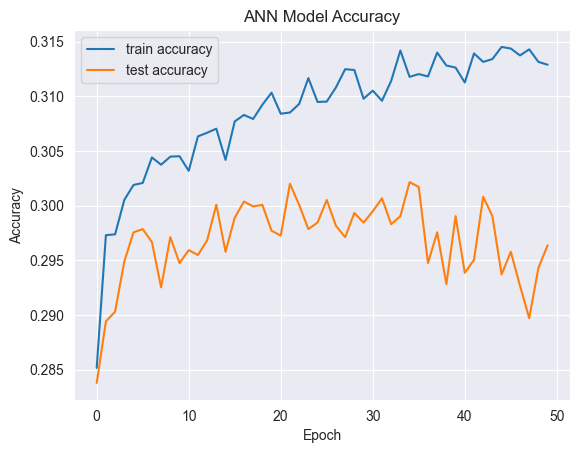

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  


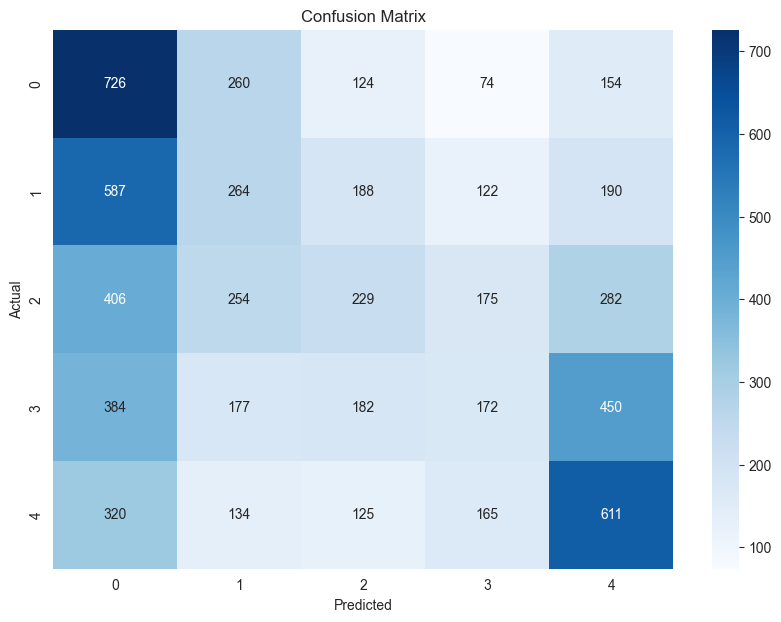

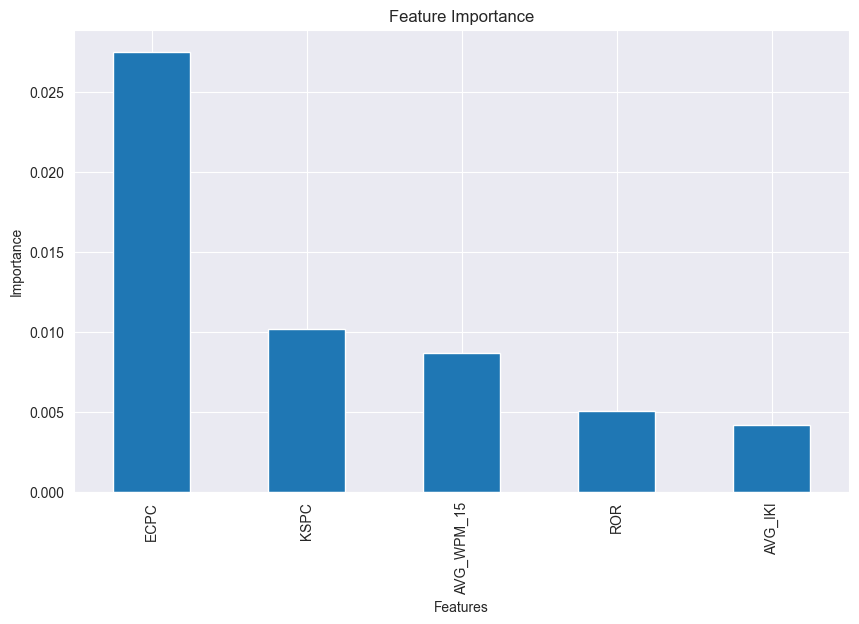

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Specify the features to be used
features = [
    'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR'
]

# Separate features and target
X = df[features]
y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
participant_ids = df['PARTICIPANT_ID']

# Encode any categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Ensure unique PARTICIPANT_IDs in train and test sets
unique_ids = participant_ids.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_mask = participant_ids.isin(train_ids)
test_mask = participant_ids.isin(test_ids)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable for ANN
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Build the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print("ANN Accuracy: ", test_acc)

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Print confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculate feature importance using permutation importance
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
importance = result.importances_mean

# Visualize feature importance
feature_importance = pd.Series(importance, index=features)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()

Epoch 1/50


D:\Coding_Projects\erkd_schieben\erkd\.venv\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


845/845 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.2766 - loss: 1.5638 - val_accuracy: 0.2884 - val_loss: 1.5425
Epoch 2/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.2988 - loss: 1.5368 - val_accuracy: 0.2896 - val_loss: 1.5394
Epoch 3/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3007 - loss: 1.5355 - val_accuracy: 0.2971 - val_loss: 1.5376
Epoch 4/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3040 - loss: 1.5309 - val_accuracy: 0.2981 - val_loss: 1.5379
Epoch 5/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3053 - loss: 1.5306 - val_accuracy: 0.2956 - val_loss: 1.5363
Epoch 6/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3030 - loss: 1.5351 - val_accuracy: 0.2934 - val_loss: 1.5359
Epoch 7/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3063 - loss: 1.5309 - val_accuracy: 0.2934 - val_loss: 1.5361
Epoch 8/50
845/845 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.3095 - loss: 1.5274 - val_accuracy: 0.2930 - val_

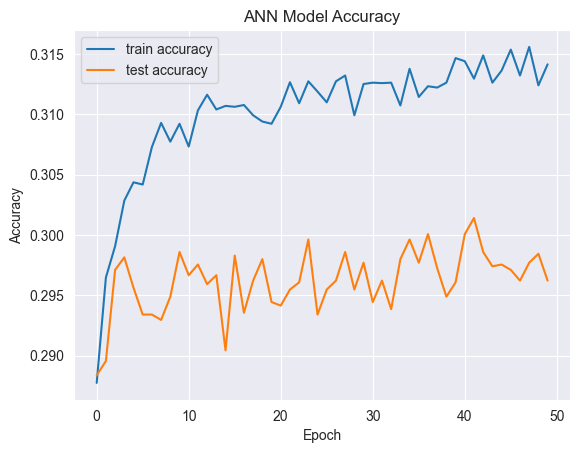

212/212 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [10]:
# save ann 


import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.inspection import permutation_importance
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('demographics_csv/balanced_age.csv')

# Specify the features to be used
features = [
    'AVG_WPM_15', 'AVG_IKI', 'ECPC', 'KSPC', 'ROR'
]

# Separate features and target
X = df[features]
y = df[[col for col in df.columns if col.startswith('AGE_CLASS_')]].idxmax(axis=1).apply(lambda x: int(x.split('_')[-1]))
participant_ids = df['PARTICIPANT_ID']

# Encode any categorical variables
label_encoder = LabelEncoder()
for column in X.select_dtypes(include=['object']).columns:
    X[column] = label_encoder.fit_transform(X[column])

# Ensure unique PARTICIPANT_IDs in train and test sets
unique_ids = participant_ids.unique()
train_ids, test_ids = train_test_split(unique_ids, test_size=0.2, random_state=42)
train_mask = participant_ids.isin(train_ids)
test_mask = participant_ids.isin(test_ids)

X_train, X_test = X[train_mask], X[test_mask]
y_train, y_test = y[train_mask], y[test_mask]

# Scale the features (standardization)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# One-hot encode the target variable for ANN
encoder = OneHotEncoder(sparse_output=False)
y_train_encoded = encoder.fit_transform(y_train.values.reshape(-1, 1))
y_test_encoded = encoder.transform(y_test.values.reshape(-1, 1))

# Build the ANN model
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(X_train.shape[1],)))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(y_train_encoded.shape[1], activation='softmax'))

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_data=(X_test, y_test_encoded))

# Evaluate the model
test_loss, test_acc = model.evaluate(X_test, y_test_encoded)
print("ANN Accuracy: ", test_acc)

# Plotting training & validation accuracy
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='test accuracy')
plt.title('ANN Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Print and save confusion matrix
y_pred = model.predict(X_test)
y_pred_classes = y_pred.argmax(axis=1)
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('cm_ann_agepred.pdf', bbox_inches='tight')
plt.close()

# Save confusion matrix as CSV
conf_matrix_df = pd.DataFrame(conf_matrix, index=encoder.categories_[0], columns=encoder.categories_[0])
conf_matrix_df.to_csv('cm_ann_agepred.csv')

# Calculate feature importance using permutation importance
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
result = permutation_importance(knn, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)
importance = result.importances_mean

# Visualize and save feature importance
feature_importance = pd.Series(importance, index=features)
feature_importance.sort_values(ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar')
plt.title('Feature Importance')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.savefig('fip_ann_agepred.pdf', bbox_inches='tight')
plt.close()

# Save feature importance as CSV
feature_importance_df = feature_importance.reset_index()
feature_importance_df.columns = ['Feature', 'Importance']
feature_importance_df.to_csv('fip_ann_agepred.csv', index=False)